# **DAML Group Assignment - Predictive Traffic Modelling**


---



### Loading Dataset

In [ ]:
import io
import requests
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Navigate to the folder containing our data
# To make sure we have the correct datasets
import os
data_path = '/content/gdrive/MyDrive/Web_Traffic_Data'

os.listdir(data_path)  # This will list all the files in the directory(datasets)

['traffic_may_2023.xlsx',
 'traffic_june_2023.xlsx',
 'traffic_july_2023.xlsx',
 'traffic_august_2023.xlsx',
 'traffic_september_2023.xlsx']

### Load All The Libraries

In [ ]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

### Data Preparation

In [ ]:
# Initialize an empty list to hold dataframes
dataframes = []

# Loop through all files in the directory
for file in os.listdir(data_path):
    if file.endswith('.xlsx'):  # This is to make sure it proceed with Excel File
        file_path = os.path.join(data_path, file)
        df = pd.read_excel(file_path, sheet_name='All')
        df['Month'] = file.split('_')[1]  # Extract month info from filename
        dataframes.append(df)

# Combine all monthly dataframes into one
combined_data = pd.concat(dataframes, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

### Exploratory Data Analysis (EDA)

In [ ]:
# Below codes shows the basic understanding of our dataset
# To display the No. of Rows and No. of Columns
print("Print number of rows: {}".format(len(combined_data)))
print("Print number of columns: {}".format(len(combined_data.columns)))

# Simple examples of the datasets
print("Listing all columns: ")
print(combined_data.head())
print()

# Basic Informations
print("Display basic information of the columns: ")
print(combined_data.info())

Print number of rows: 168
Print number of columns: 10
Listing all columns: 
                    Date  Page Views  Avg. Page Views  Avg. Time Spent  \
0  01-05-2023-31-05-2023       1,593             1.73         00:00:33   
1                    NaN         NaN              NaN              NaN   
2                   Date  Page Views  Avg. Page Views  Avg. Time Spent   
3             01-05-2023           3             3.00         00:00:24   
4             02-05-2023           6             2.00         00:01:18   

   Bounce Rate  Visitors  New Visitors  Existing Visitors  New Followers Month  
0       87.08%       921           898                 23             28   may  
1          NaN       NaN           NaN                NaN            NaN   may  
2  Bounce Rate  Visitors  New Visitors  Existing Visitors  New Followers   may  
3        0.00%         1             0                  1              0   may  
4        0.00%         3             2                  1              0  

### Identify any missing values

In [ ]:
# Check for any missing values
print(combined_data.isnull().sum())

Date                 5
Page Views           5
Avg. Page Views      5
Avg. Time Spent      5
Bounce Rate          5
Visitors             5
New Visitors         5
Existing Visitors    5
New Followers        5
Month                0
dtype: int64


### Data Preprocessing

In [ ]:
# Removing missing values
# [Before]
print("Before remove missing values: [{} rows x {} col]".format(combined_data.shape[0],combined_data.shape[1] ))
print (combined_data.isnull().sum())

for column in combined_data.columns:
    if combined_data[column].dtype == 'object':
        mode_value = combined_data[column].mode()[0]
        combined_data[column].fillna(mode_value, inplace=True)

# Missing Values Removed
# [After]
combined_data = (combined_data.dropna())
print("\nAfter remove missing values: [{} rows x {} col]".format(combined_data.shape[0],combined_data.shape[1] ))
print (combined_data.isnull().sum())

Before remove missing values: [168 rows x 10 col]
Date                 5
Page Views           5
Avg. Page Views      5
Avg. Time Spent      5
Bounce Rate          5
Visitors             5
New Visitors         5
Existing Visitors    5
New Followers        5
Month                0
dtype: int64

After remove missing values: [168 rows x 10 col]
Date                 0
Page Views           0
Avg. Page Views      0
Avg. Time Spent      0
Bounce Rate          0
Visitors             0
New Visitors         0
Existing Visitors    0
New Followers        0
Month                0
dtype: int64


<ipython-input-7-4e564a55371e>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data[column].fillna(mode_value, inplace=True)


# Objective 1 : Predictive Traffic Modeling


## Section 1: Setup and Data Preparation

In [ ]:
# ----------------------------------------------------------------------
#                           Feature Selection
# ----------------------------------------------------------------------

# Feature Selection
X = combined_data[['Visitors', 'Bounce Rate', 'Avg. Time Spent']]
y = combined_data['Page Views']

# ----------------------------------------------------------------------
#                         Data Type Conversion
# ----------------------------------------------------------------------

# Data Type Conversion for 'Visitors' Column
# Remove commas and convert 'Visitors' column to numeric.
X['Visitors'] = pd.to_numeric(X['Visitors'].str.replace(',', ''), errors='coerce')
combined_data['Visitors'] = pd.to_numeric(combined_data['Visitors'].str.replace(',', ''), errors='coerce')

# Data Type Conversion for 'Bounce Rate' Column
# Remove the percentage signs and convert 'Bounce Rate' to a numeric float (value between 0 and 1).
X['Bounce Rate'] = X['Bounce Rate'].str.rstrip('%').replace('', np.nan, regex=True)
X['Bounce Rate'] = pd.to_numeric(X['Bounce Rate'], errors='coerce') / 100

# Data Type Conversion for 'Avg. Time Spent' Column
# Convert 'Avg. Time Spent' to numeric (total seconds).
X['Avg. Time Spent'] = pd.to_timedelta(X['Avg. Time Spent'], errors='coerce').dt.total_seconds()

# Data Type Conversion for 'Page Views' Column
# Convert the target variable 'Page Views' to numeric, handling commas.
y = pd.to_numeric(y.str.replace(',', ''), errors='coerce')
combined_data['Page Views'] = pd.to_numeric(combined_data['Page Views'].str.replace(',', ''), errors='coerce')

# ----------------------------------------------------------------------
#                               Data Cleaning
# ----------------------------------------------------------------------

# Handle Missing Values
# Remove rows with any NaN values that resulted from conversion errors in X.
X = X.dropna()

# Align Target Variable with Cleaned Feature Data
# Update the 'y' target variable to match the indices of the cleaned 'X'.
y = y[X.index]


<ipython-input-8-d2354bbb8b6d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Visitors'] = pd.to_numeric(X['Visitors'].str.replace(',', ''), errors='coerce')
<ipython-input-8-d2354bbb8b6d>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Bounce Rate'] = X['Bounce Rate'].str.rstrip('%').replace('', np.nan, regex=True)
<ipython-input-8-d2354bbb8b6d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


## Section 2: Data Splitting and Feature Scaling

In [ ]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

## Section 3: Model Training

### Model Evaluation Function (Performance Metrics)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Create a formatted table
    print(f"{'Model':<20} {'MAE':>10} {'MSE':>10} {'RMSE':>10} {'R2':>10}")
    print(f"{model_name:<20} {mae:>10.2f} {mse:>10.2f} {rmse:>10.2f} {r2:>10.2f}")
    print("-" * 66)

### Linear Regression

In [ ]:
# Initialize Linear Regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train_scaled, y_train)

# Make Predictions
lr_preds = lr.predict(X_test_scaled)

# Evaluate Model
evaluate_model(y_test, lr_preds, "Linear Regression")

Model                       MAE        MSE       RMSE         R2
Linear Regression        245.63  967888.81     983.81       0.82
------------------------------------------------------------------


### Support Vector Regression

In [ ]:
# Initialize SVR model
svr = SVR()

# Train the model
svr.fit(X_train_scaled, y_train)

# Make Predictions
svr_preds = svr.predict(X_test_scaled)

# Evaluate Model
evaluate_model(y_test, svr_preds, "Support Vector Regressor")

Model                       MAE        MSE       RMSE         R2
Support Vector Regressor     736.40 5715548.33    2390.72      -0.08
------------------------------------------------------------------


### KNN Regression

In [ ]:
# Define Parameter Grid for tuning
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan','minkowski'],
    'leaf_size': [20, 30, 40, 50]
}

# Initialize cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize KNN Regressor
knn = KNeighborsRegressor()

# Use GridSearchCV for hyperparameter tuning
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit and Tune the model
grid_search_knn.fit(X_train_scaled, y_train)

# Get best model from tuning
best_knn = grid_search_knn.best_estimator_

# Make Predictions
knn_preds = best_knn.predict(X_test_scaled)

# Evaluate Model
evaluate_model(y_test, knn_preds, "KNN Regressor")

Model                       MAE        MSE       RMSE         R2
KNN Regressor            197.83  158144.16     397.67       0.97
------------------------------------------------------------------


### Section 4: Model Evaluation (All Results)

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Evaluate all models and store results
model_results = {
    "Linear Regression": evaluate_model(y_test, lr_preds, "Linear Regression"),
    "Support Vector Regressor": evaluate_model(y_test, svr_preds, "Support Vector Regressor"),
    "KNN Regressor": evaluate_model(y_test, knn_preds, "KNN Regressor")
}

# Print results in a formatted table
print(f"{'Model':<25} {'MAE':>10} {'MSE':>10} {'RMSE':>10} {'R2':>10}")
print("-" * 65)  # This is for separator line
for model_name, results in model_results.items():
    mae, mse, rmse, r2 = results
    print(f"{model_name:<25} {mae:>10.2f} {mse:>10.2f} {rmse:>10.2f} {r2:>10.2f}")

Model                            MAE        MSE       RMSE         R2
-----------------------------------------------------------------
Linear Regression             245.63  967888.81     983.81       0.82
Support Vector Regressor      736.40 5715548.33    2390.72      -0.08
KNN Regressor                 197.83  158144.16     397.67       0.97


### Section 5 : Visualizations

#### Actual vs. Predicted Scatter Plot


---

This visual is to compare the different model's predicted values to the actual values and assess the model's accuracy.


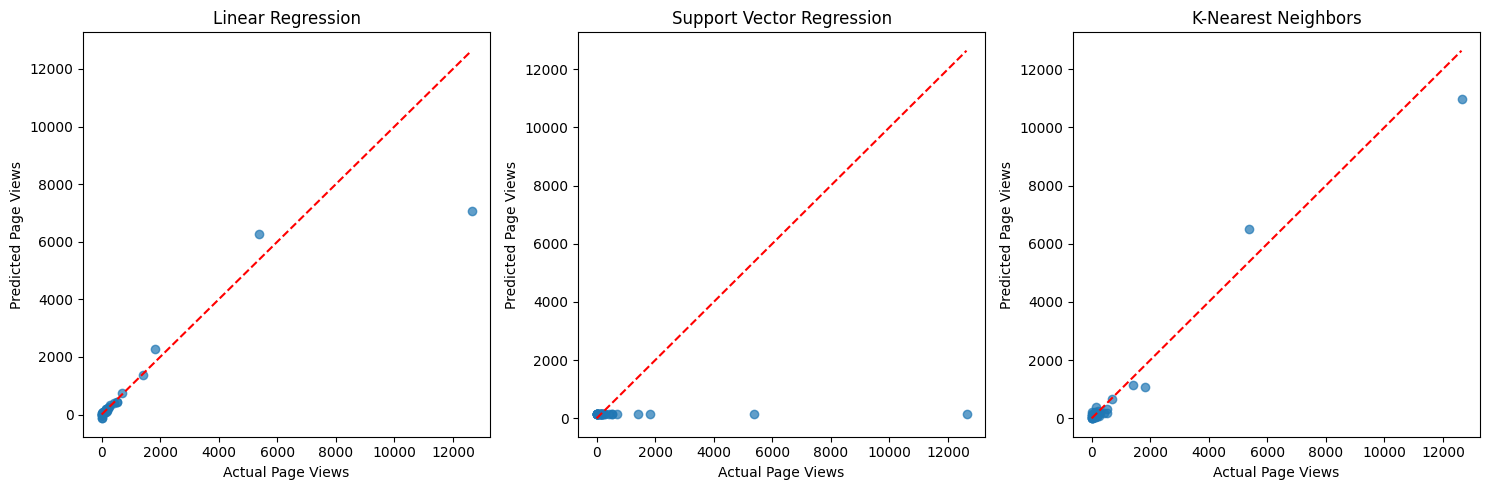

In [ ]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot for Linear Regression
axes[0].scatter(y_test, lr_preds, alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
axes[0].set_xlabel('Actual Page Views')
axes[0].set_ylabel('Predicted Page Views')
axes[0].set_title('Linear Regression')

# Plot for Support Vector Regression
axes[1].scatter(y_test, svr_preds, alpha=0.7)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
axes[1].set_xlabel('Actual Page Views')
axes[1].set_ylabel('Predicted Page Views')
axes[1].set_title('Support Vector Regression')

# Plot for K-Nearest Neighbors
axes[2].scatter(y_test, knn_preds, alpha=0.7)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
axes[2].set_xlabel('Actual Page Views')
axes[2].set_ylabel('Predicted Page Views')
axes[2].set_title('K-Nearest Neighbors')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Feature Correlation Matrix


---
This is to visualize the relationships between the **features** and the **target variable**.
- features = [ 'Visitors', 'Bounce Rate', 'Avg. Time Spent' ]
- target variable = [ 'page views' ]



<ipython-input-17-21e76e36c8fb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Bounce Rate'] = combined_data['Bounce Rate'].astype(str)
<ipython-input-17-21e76e36c8fb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['Bounce Rate'] = pd.to_numeric(combined_data['Bounce Rate'].str.rstrip('%'), errors='coerce')
<ipython-input-17-21e76e36c8fb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

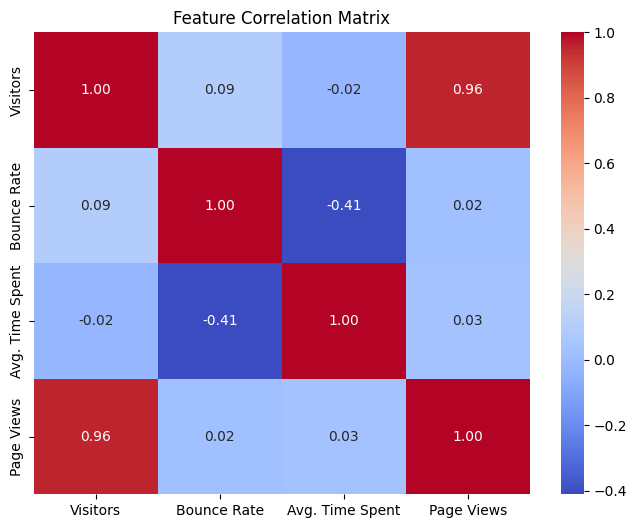

In [ ]:
# Remove rows with header strings "Bounce Rate" in combined_data
combined_data = combined_data[combined_data['Bounce Rate'] != 'Bounce Rate']

# Convert 'Bounce Rate' to string before applying str methods
combined_data['Bounce Rate'] = combined_data['Bounce Rate'].astype(str)

# Now convert 'Bounce Rate' to numeric (remove % and convert to float)
combined_data['Bounce Rate'] = pd.to_numeric(combined_data['Bounce Rate'].str.rstrip('%'), errors='coerce')
combined_data['Bounce Rate'] = combined_data['Bounce Rate'].fillna(combined_data['Bounce Rate'].mean())
combined_data['Bounce Rate'] = combined_data['Bounce Rate'] / 100

# This line is added to convert the 'Avg. Time Spent' column to numeric (total seconds)
combined_data['Avg. Time Spent'] = pd.to_timedelta(combined_data['Avg. Time Spent'], errors='coerce').dt.total_seconds()

# Calculate correlation matrix after conversion
correlation_matrix = combined_data[['Visitors', 'Bounce Rate', 'Avg. Time Spent', 'Page Views']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

#### Bar Chart for Monthly Page View

---
This is to display the total page view out of different months.


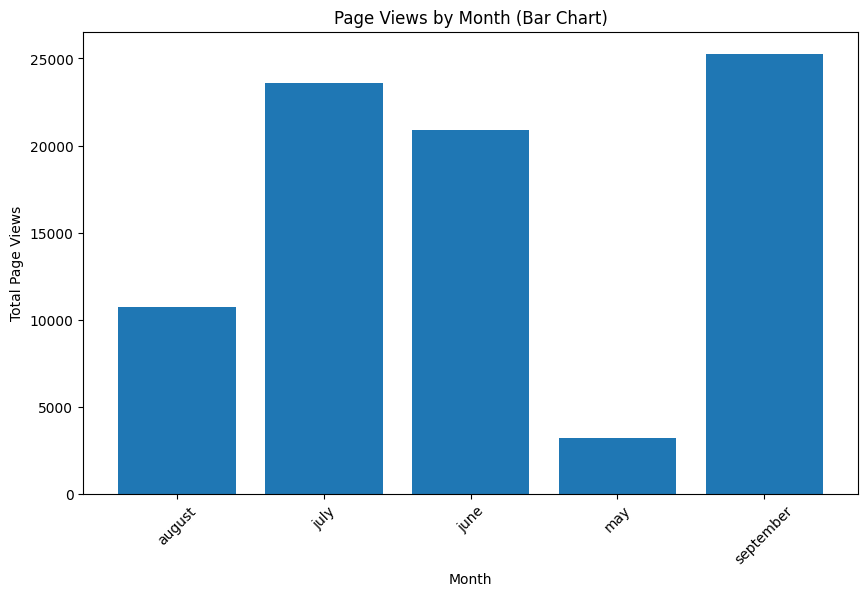

In [ ]:
# Group data by month and sum page views
monthly_page_views = combined_data.groupby('Month')['Page Views'].sum().reset_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(monthly_page_views['Month'], monthly_page_views['Page Views'])
plt.title('Page Views by Month (Bar Chart)')
plt.xlabel('Month')
plt.ylabel('Total Page Views')
plt.xticks(rotation=45)
plt.show()

#### Residual Plots: Model Comparison

---

This visual compares the residual patterns across the three models to assess their performance and assumptions.

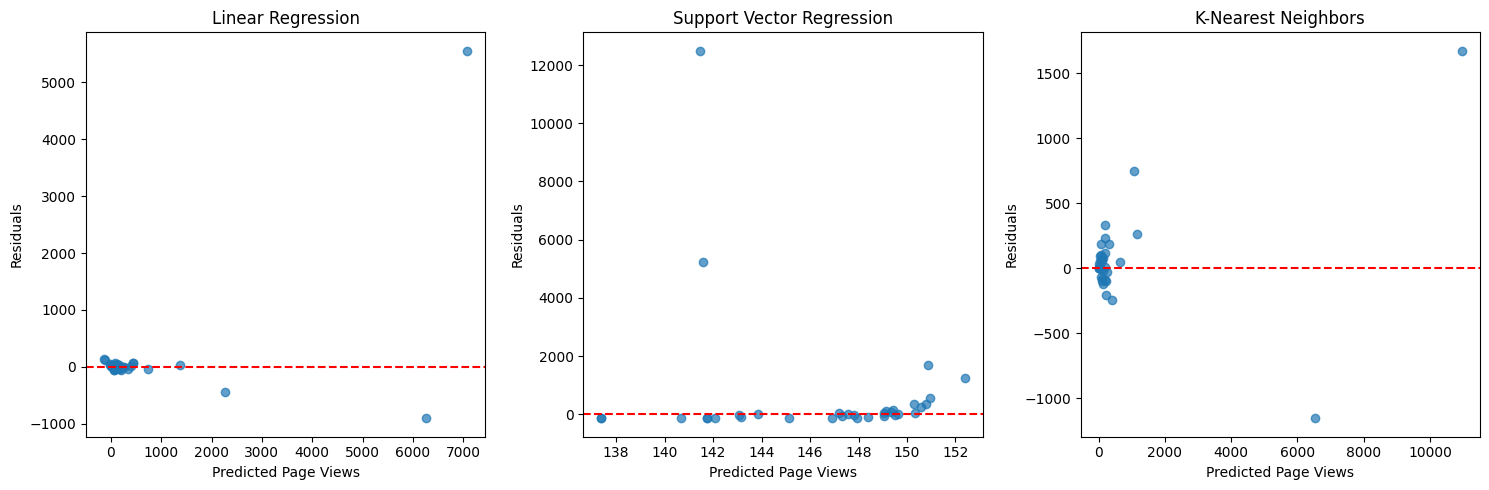

In [ ]:
# Calculate residuals for each model
residuals_lr = y_test - lr_preds
residuals_svr = y_test - svr_preds
residuals_knn = y_test - knn_preds

# Create a figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot for Linear Regression
axes[0].scatter(lr_preds, residuals_lr, alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Page Views')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression')

# Plot for Support Vector Regression
axes[1].scatter(svr_preds, residuals_svr, alpha=0.7)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Page Views')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Support Vector Regression')

# Plot for K-Nearest Neighbors
axes[2].scatter(knn_preds, residuals_knn, alpha=0.7)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Page Views')
axes[2].set_ylabel('Residuals')
axes[2].set_title('K-Nearest Neighbors')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()